# Imports

In [33]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo import draw
from Bio import SeqIO
from Bio import Phylo, AlignIO
import subprocess
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math
import scipy.linalg as la
#from skbio import DistanceMatrix

# Read sequence data and metadata
Read in the SARS-CoV-2 multiple sequence alignment.

12 SARS-CoV-2 genomic sequences from different locations and hosts were retrieved from NCBI Virus and aligned using the alignment function provided by the platform (https://www.ncbi.nlm.nih.gov/labs/virus/vssi/).

MSA.fasta was created by replacing the sequence header of the downloaded ncbi msa file with only the accession id and the file suffix -aln with .fasta.

In [34]:
align = AlignIO.read("MSA.fasta", "fasta") # <- we dont actally need the alignment file here, the method is designed for unaligned sequences
#print(align)
#file1 = open("MSA.fasta","r") 
#file2 = open("MSAfile.txt","w+") 
#text=[]
#for line in file1:
#    text.append(str(line))
#    #text.append('\n')
#file1.close()
#file2.write("".join(text))
#file2.close()
seq1=align[0].seq
#print(seq1)

### Transform Sequence into graph

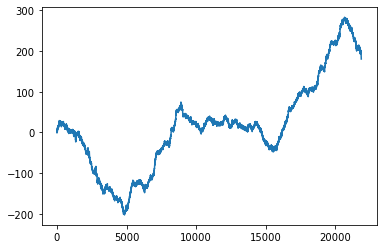

In [35]:
n=0.5
m=0.75
def calculateXY(seq):
    A_i=0
    C_i=0
    G_i=0
    T_i=0
    i=0
    X=[]
    Y=[]
    for ch in seq:
        if ch=='A':
            A_i+=1
        if ch=='C':
            C_i+=1
        if ch=='G':
            G_i+=1
        if ch=='T':
            T_i+=1
        X.append(A_i*m+G_i*math.sqrt(n)+C_i*math.sqrt(n)+T_i*m)
        Y.append(A_i*math.sqrt(n)*(-1)-G_i*m+C_i*m+T_i*math.sqrt(n))
        i+=1
    return X, Y

X1,Y1=calculateXY(seq1)  
plt.plot(X1, Y1)

In [36]:
def calAllXY(AlignO):
    AllX=[]
    AllY=[]
    for seq_i in AlignO:
        Xi,Yi = calculateXY(seq_i)
        AllX.append(Xi)
        AllY.append(Yi)
    return AllX, AllY

Xs, Ys = calAllXY(align)
#print(len(Xs))

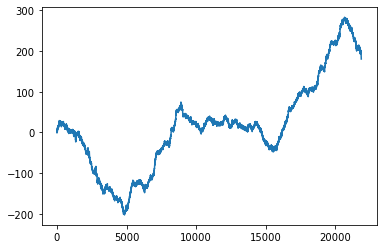

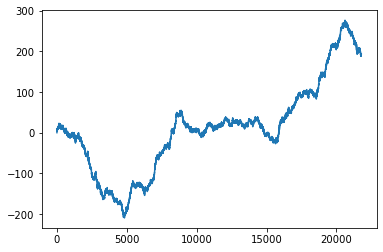

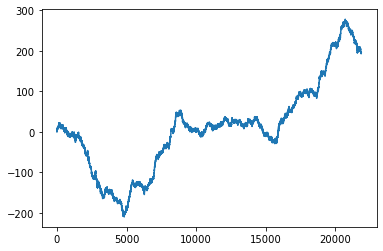

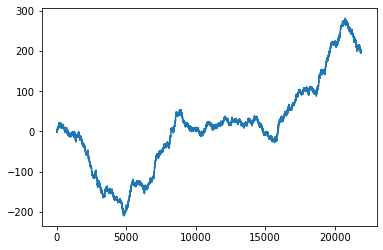

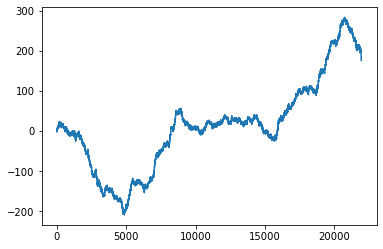

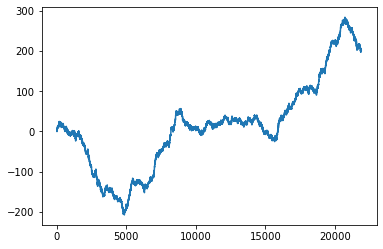

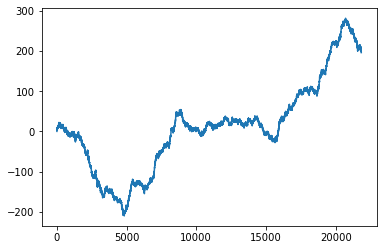

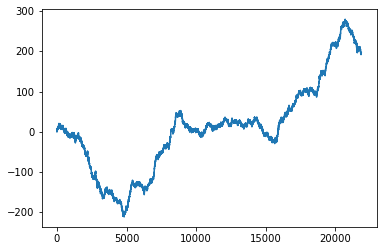

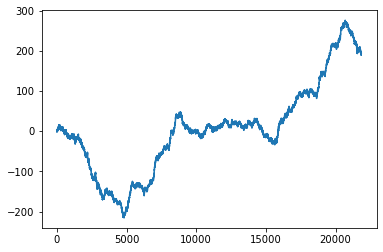

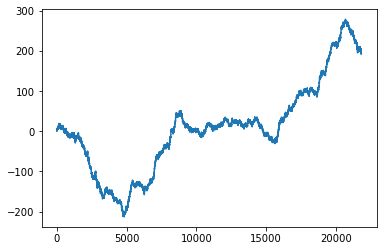

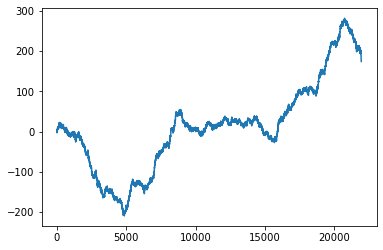

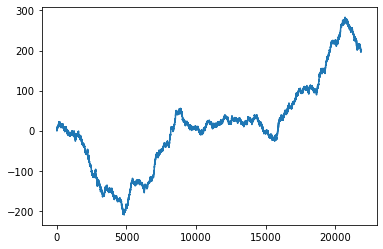

In [37]:
def PlotAll(AllX, AllY):
    for i in range(len(AllX)):
        Xi=AllX[i]
        Yi=AllY[i]
        plt.plot(Xi, Yi)
        plt.show()

PlotAll(Xs, Ys)

In [38]:
erg0=0
Xs0, Ys0 = calCenter(Xs[0],Ys[0])
for i in range(len(Xs[0])):
    erg0+=Xs[0][i]-Xs0*Ys[0][i]-Ys0
erg0
# 17116867982.10221

-4279057075.4733543

### Code Equations from the Paper and Calculate the Distance Matrix

In [39]:
# coordinates of the geometrical center of the points
def calCenter(X,Y):
    X0=sum(X)/len(X) # <- was sum(X)/len(Xs), is now sum(X)/len(X)
    Y0=sum(Y)/len(Y) # <- was sum(Y)/len(Ys), is now sum(Y)/len(Y)
    return X0, Y0

# formula of the covariance matrix CM
def CMsum(X,Y):
    X0, Y0 = calCenter(X,Y)
    erg=0
    for i in range(len(X)):
        erg+=(X[i]-X0)*(Y[i]-Y0) # has now brackets instead of X[i]-X0*Y[i]-Y0
    return erg/len(X)

# the elements of the covariance matrix CM of the points 
def calCM(X,Y):
    CM=np.zeros((2,2))
    CM[0,0]=CMsum(X,X)
    CM[1,1]=CMsum(Y,Y)
    CM[1,0]=CMsum(X,Y)
    CM[0,1]=CM[1,0]
    return CM
    
print(calCM(Xs[0], Ys[0]))
print(calCM(Xs[0], Ys[0]).transpose().dot(calCM(Xs[0], Ys[0])))
print(calCM(Xs[1], Ys[1]))
print(calCM(Xs[2], Ys[2]))

[[3.98307036e+07 5.41582212e+05]
 [5.41582212e+05 1.22418462e+04]]
[[1.58677826e+15 2.15782305e+13]
 [2.15782305e+13 2.93461155e+11]]
[[3.97647067e+07 5.56599901e+05]
 [5.56599901e+05 1.20320104e+04]]
[[4.01174249e+07 5.62230932e+05]
 [5.62230932e+05 1.21692038e+04]]


In [40]:
#CM1=calCM(Xs[0],Ys[0])
#eigwert, eigvec = la.eig(CM1)
#print(eigwert)
#print(eigvec)

def distanceCentersIJ(Xi, Yi, Xj, Yj):
    xi0, yi0 = calCenter(Xi,Yi)
    xj0, yj0 = calCenter(Xj,Yj)
    return math.sqrt((xi0-xj0)**2+(yi0-yj0)**2)

def ThetaIJ(CM_i, CM_j):
    eigwert_i, EV_i = la.eig(CM_i)
    eigwert_j, EV_j = la.eig(CM_j)
    erg=math.acos(EV_i[0].dot(EV_j[0])/(np.linalg.norm(EV_i[0])*np.linalg.norm(EV_j[0])))+math.acos(EV_i[1].dot(EV_j[1])/(np.linalg.norm(EV_i[1])*np.linalg.norm(EV_j[1])))
    return erg

def DistanceIJ(Xi, Yi, Xj, Yj):
    CM_i=calCM(Xi, Yi)
    CM_j=calCM(Xj, Yj)
    return distanceCentersIJ(Xi, Yi, Xj, Yj) * ThetaIJ(CM_i, CM_j)
    

#print(ThetaIJ(calCM(Xs[0], Ys[0]),calCM(Xs[1], Ys[1])))
print(DistanceIJ(Xs[0], Ys[0], Xs[1], Ys[1])==DistanceIJ(Xs[1], Ys[1], Xs[0], Ys[0]))

def genDistanceMatrix(Xs, Ys):
    DM=np.zeros((len(Xs), len(Xs)))
    for i in range(len(Xs)):
        for j in range(len(Xs)):
            if i==j:
                DM[i,j]=0
            else:
                DM[i,j]=DistanceIJ(Xs[i], Ys[i], Xs[j], Ys[j])
    return DM

DistanceM=genDistanceMatrix(Xs, Ys)
print(DistanceM)

True
[[0.00000000e+00 2.01648101e-02 4.07241389e-03 3.33700454e-02
  3.86963884e-02 2.71153851e-02 4.93607298e-03 7.40387974e-03
  2.18209892e-02 1.30750249e-02 3.54561324e-02 3.06612253e-03]
 [2.01648101e-02 0.00000000e+00 7.86480591e-04 2.51375086e-02
  3.26144738e-02 2.41444896e-02 1.16647778e-02 1.04384739e-02
  8.02882189e-03 8.41610987e-03 2.64033962e-02 1.78580368e-02]
 [4.07241389e-03 7.86480591e-04 0.00000000e+00 1.28908889e-02
  1.74027403e-02 1.13943743e-02 7.05299758e-04 6.71190697e-04
  6.68068805e-03 2.87746077e-03 1.38628596e-02 2.03658017e-03]
 [3.33700454e-02 2.51375086e-02 1.28908889e-02 0.00000000e+00
  2.19832440e-04 1.94642140e-04 5.41627585e-04 1.92540410e-04
  4.79387831e-03 8.07412015e-05 1.54049041e-05 6.40539531e-03]
 [3.86963884e-02 3.26144738e-02 1.74027403e-02 2.19832440e-04
  0.00000000e+00 6.53155996e-04 3.24032039e-03 4.19363636e-03
  2.45678634e-04 4.50938417e-03 8.02345672e-05 3.14771997e-03]
 [2.71153851e-02 2.41444896e-02 1.13943743e-02 1.94642140e-0

### Use Distance Matrix to genarate the Tree

In [42]:
accession_metainfo = pd.read_csv("sequence_metadata.csv", index_col=0, sep='\t')
accession_metainfo.head()

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus,country,region
0,MT658507.1,2020-06-23T00:00:00Z,Severe acute respiratory syndrome-related coro...,29799,Egypt,Homo sapiens,oronasopharynx,2020-06-02,MT658507.1,Severe acute respiratory syndrome-related coro...,Egypt,no_data
1,MT641501.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29868,USA: Washington,Homo sapiens,NaN,2020-04-11,MT641501.1,Severe acute respiratory syndrome-related coro...,USA,Washington
2,MT641645.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29813,Australia: Northern Territory,Homo sapiens,NaN,2020-02-21,MT641645.1,Severe acute respiratory syndrome-related coro...,Australia,Northern Territory
3,MT635269.1,2020-06-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,29800,"India: Gujarat, Ahmedabad",Homo sapiens,NaN,2020-06-03,MT635269.1,Severe acute respiratory syndrome-related coro...,India,"Gujarat, Ahmedabad"
4,MT582453.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582453.1,Severe acute respiratory syndrome-related coro...,Germany,Dusseldorf


In [44]:
ids = accession_metainfo['Accession'].tolist()
def newDistanceMatrix(Xs, Ys, ids):
    matrix = [[]]
    for i in range(len(Xs)):
        newrow=[]
        for j in range(len(Xs)):
            if i==j:
                newrow.append(0)
                matrix.append(newrow)
                break
            else:
                newrow.append(DistanceIJ(Xs[i], Ys[i], Xs[j], Ys[j]))
    matrix=matrix[1:]
    dm = _DistanceMatrix(ids, matrix)
    return dm

curveDM=newDistanceMatrix(Xs, Ys, ids)
type(curveDM)

Bio.Phylo.TreeConstruction.DistanceMatrix

In [45]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(curveDM)
code=accession_metainfo.index
host=accession_metainfo["Host"]
loc=accession_metainfo["Geo_Location"]

In [84]:
# function for the phylogenetic tree labels
def get_label(leaf):
    searchname=leaf.name
    for i in range(0, len(code)):
        if searchname==code[i]:
            name=host[i] + ": " + loc[i]
            return name

In [70]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner11')
        Clade(branch_length=0.05995839249916471, name='Inner10')
            Clade(branch_length=0.0024567741396591784, name='Inner9')
                Clade(branch_length=0.0014518250918810795, name='Inner7')
                    Clade(branch_length=0.000801871032408974, name='Inner1')
                        Clade(branch_length=0.0001002338790511148, name='MN908947.3')
                        Clade(branch_length=0.0001002338790511148, name='MT350282.1')
                    Clade(branch_length=0.00036752422318747646, name='Inner4')
                        Clade(branch_length=0.0005345806882726123, name='MT263074.1')
                        Clade(branch_length=0.0005345806882726123, name='MT641501.1')
                Clade(branch_length=0.0012471809221516646, name='Inner8')
                    Clade(branch_length=0.0005951386568660497, name='Inner2')
                        Clade(branch_length=0.0003508185766789018, name='MT525

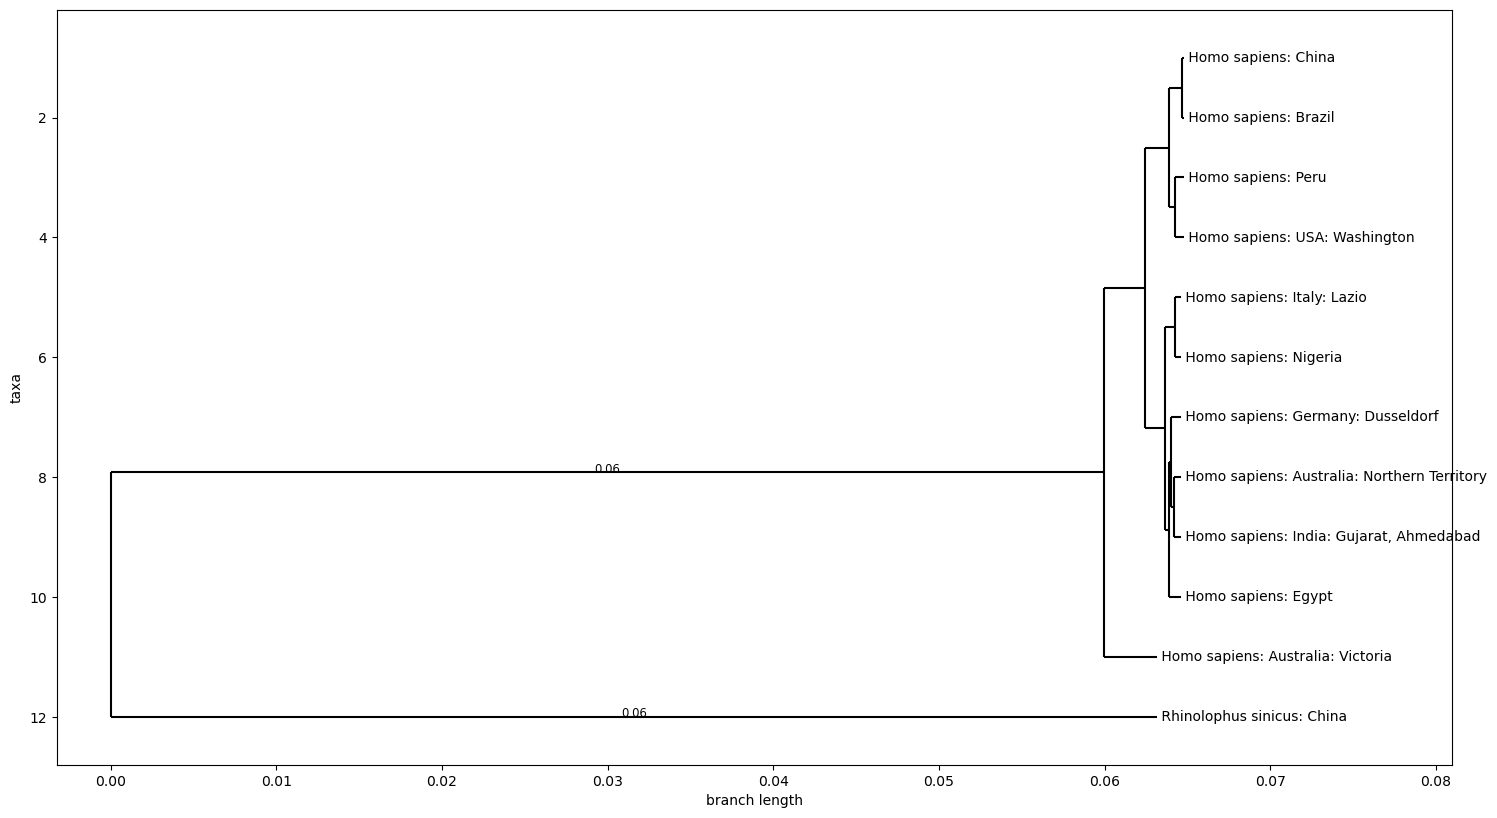

In [73]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('Curve_UPGMA_tree.png')

## Curved-based Tree with more sequences

In [75]:
align_week11 = AlignIO.read("sequences_week11.fasta", "fasta") # <- yeah, here its unaligned 
accession_metainfo_w11 = pd.read_csv("sequences_week11.csv", sep=',')
accession_metainfo_w11.head()

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date
0,NC_045512,2020-01-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,China,Homo sapiens,NaN,2019-12
1,LC556316,2020-06-30T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,Japan,Homo sapiens,NaN,2020-04
2,MT679205,2020-06-30T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,USA: NY,Homo sapiens,oronasopharynx,2020-03-25
3,MT679209,2020-06-30T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,USA: NY,Homo sapiens,oronasopharynx,2020-04-09
4,MT671821,2020-06-26T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,USA: CA,Homo sapiens,NaN,2020-03-13


In [76]:
Xs_w11, Ys_w11 = calAllXY(align_week11)

In [77]:
ids_w11=accession_metainfo_w11['Accession'].tolist()
curveDM_w11=newDistanceMatrix(Xs_w11, Ys_w11, ids_w11)

In [94]:
# function for the phylogenetic tree labels
def get_label2(leaf):
    searchname=leaf.name
    for i in range(0, len(code_w11)):
        if searchname==code_w11[i] or searchname + ".3"==code_w11[i] or searchname + ".1"==code_w11[i]:
            name=host_w11[i] + ": " + loc_w11[i]
            return name

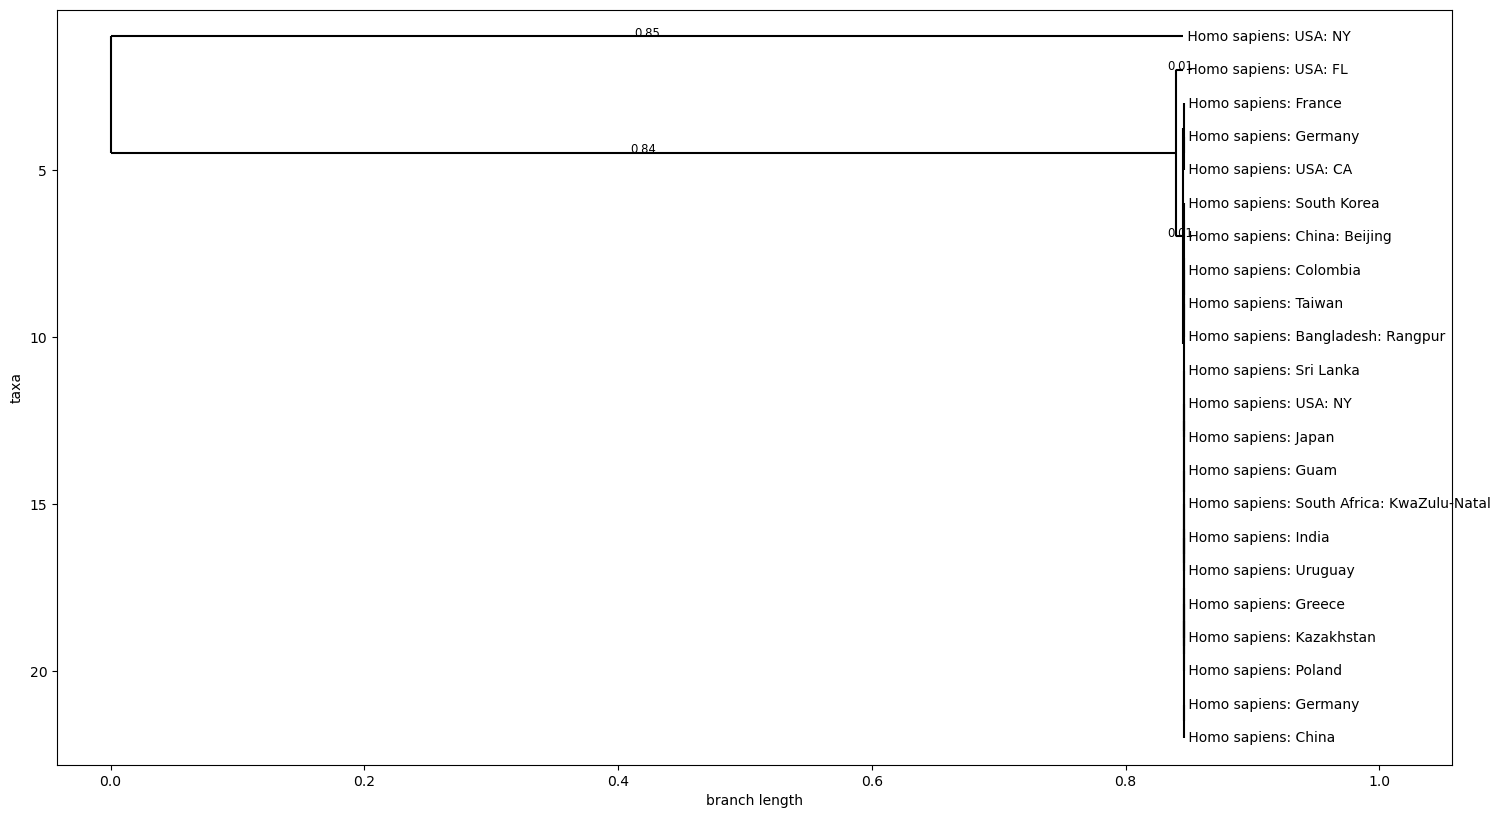

In [95]:
constructor = DistanceTreeConstructor()
tree_w11 = constructor.upgma(curveDM_w11)
code_w11=accession_metainfo_w11["Accession"]
host_w11=accession_metainfo_w11["Host"]
loc_w11=accession_metainfo_w11["Geo_Location"]

fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

#Todo: Baum ordentlich machen
Phylo.draw(tree_w11, axes=axes, label_func=get_label2, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('Curve_UPGMA_tree_w11.png')

### 

# Stuff from last week 

### Process metadata 

The metadata file was downloaded from https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&ids=MN908947%20MG772933%20MT658507%20MT576584%20MT582453%20MT525950%20MT641501%20MT350282%20MT263074%20MT641645%20MT451694%20MT635269 .

For TreeTime and Nextstrain augur:
- matched MSA sequence names and accession ids in  metadata file
- renamed collection date column in metadata to "date" (datetime format)


For Nextstrain augur refine:
- created the columns "strain" and "virus" in addition to "date" (strain = accession, virus = species)
(https://nextstrain.org/docs/tutorials/zika)

In [54]:
#accession_metainfo = pd.read_csv("original_data/sequences.csv", index_col=0)

#accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
#accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')

# TreeTime and augur require the alignment file and metadata to have matching sequence names
#new_names = []
#for elem in accession_metainfo.Accession.values:
#    if elem.startswith('MN'):
#        new_names.append(elem+'.3')
#    else:
#        new_names.append(elem+'.1')
#        accession_metainfo.Accession = new_names

# Nextstrain augur requires the metadata columns strain, virus and date
#accession_metainfo['strain'] = accession_metainfo.Accession
#accession_metainfo['virus'] = accession_metainfo.Species

#accession_metainfo.to_csv("sequence_metadata.csv")

In [56]:
accession_metainfo = pd.read_csv("sequence_metadata.csv", index_col=0, sep="\t")
accession_metainfo.head()

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus,country,region
0,MT658507.1,2020-06-23T00:00:00Z,Severe acute respiratory syndrome-related coro...,29799,Egypt,Homo sapiens,oronasopharynx,2020-06-02,MT658507.1,Severe acute respiratory syndrome-related coro...,Egypt,no_data
1,MT641501.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29868,USA: Washington,Homo sapiens,NaN,2020-04-11,MT641501.1,Severe acute respiratory syndrome-related coro...,USA,Washington
2,MT641645.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29813,Australia: Northern Territory,Homo sapiens,NaN,2020-02-21,MT641645.1,Severe acute respiratory syndrome-related coro...,Australia,Northern Territory
3,MT635269.1,2020-06-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,29800,"India: Gujarat, Ahmedabad",Homo sapiens,NaN,2020-06-03,MT635269.1,Severe acute respiratory syndrome-related coro...,India,"Gujarat, Ahmedabad"
4,MT582453.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582453.1,Severe acute respiratory syndrome-related coro...,Germany,Dusseldorf


# Infer phlyogeny
### Based on the MSA, a distance matrix is calculated for the 12 SARS-CoV2 sequences using the identity substitution model.

The identity substitution model assumes that each RNA base can only be maximally similar to itself but not transform into another base. Based on this assumption, two positions in a genomic MSA can only be considered identical (score = 1) or different (score = 0).

- Reading alignments, computing distance matrix, applying and visualizin UPGMA-inferred phylogeny: https://github.com/simonjuleseric2/covid_sequence/blob/master/coronavirus_sequence_analis.ipynb


In [58]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm = calculator.get_distance(align)

In [59]:
type(dm)

Bio.Phylo.TreeConstruction.DistanceMatrix

### Infer phylogeny using the UPGMA algorithm

UPGMA:
- distance based
- bottom-up hierarchical
- assumes a constant mutation rate

Goal:
- get general phylogeny of the SARS-CoV-2 genomes only based on sequence distance

In [60]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

#
code=accession_metainfo["Accession"]
host=accession_metainfo["Host"]
loc=accession_metainfo["Geo_Location"]

In [61]:
# function for plotting the phylogenetic tree
def get_label(leaf):
    searchname=leaf.name
    for i in range(0, len(code)):
        if searchname==code[i]:
            name=host[i] + ": " + loc[i]
            return name

In [62]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner11')
        Clade(branch_length=0.05995839249916471, name='Inner10')
            Clade(branch_length=0.0024567741396591784, name='Inner9')
                Clade(branch_length=0.0014518250918810795, name='Inner7')
                    Clade(branch_length=0.000801871032408974, name='Inner1')
                        Clade(branch_length=0.0001002338790511148, name='MN908947.3')
                        Clade(branch_length=0.0001002338790511148, name='MT350282.1')
                    Clade(branch_length=0.00036752422318747646, name='Inner4')
                        Clade(branch_length=0.0005345806882726123, name='MT263074.1')
                        Clade(branch_length=0.0005345806882726123, name='MT641501.1')
                Clade(branch_length=0.0012471809221516646, name='Inner8')
                    Clade(branch_length=0.0005951386568660497, name='Inner2')
                        Clade(branch_length=0.0003508185766789018, name='MT525

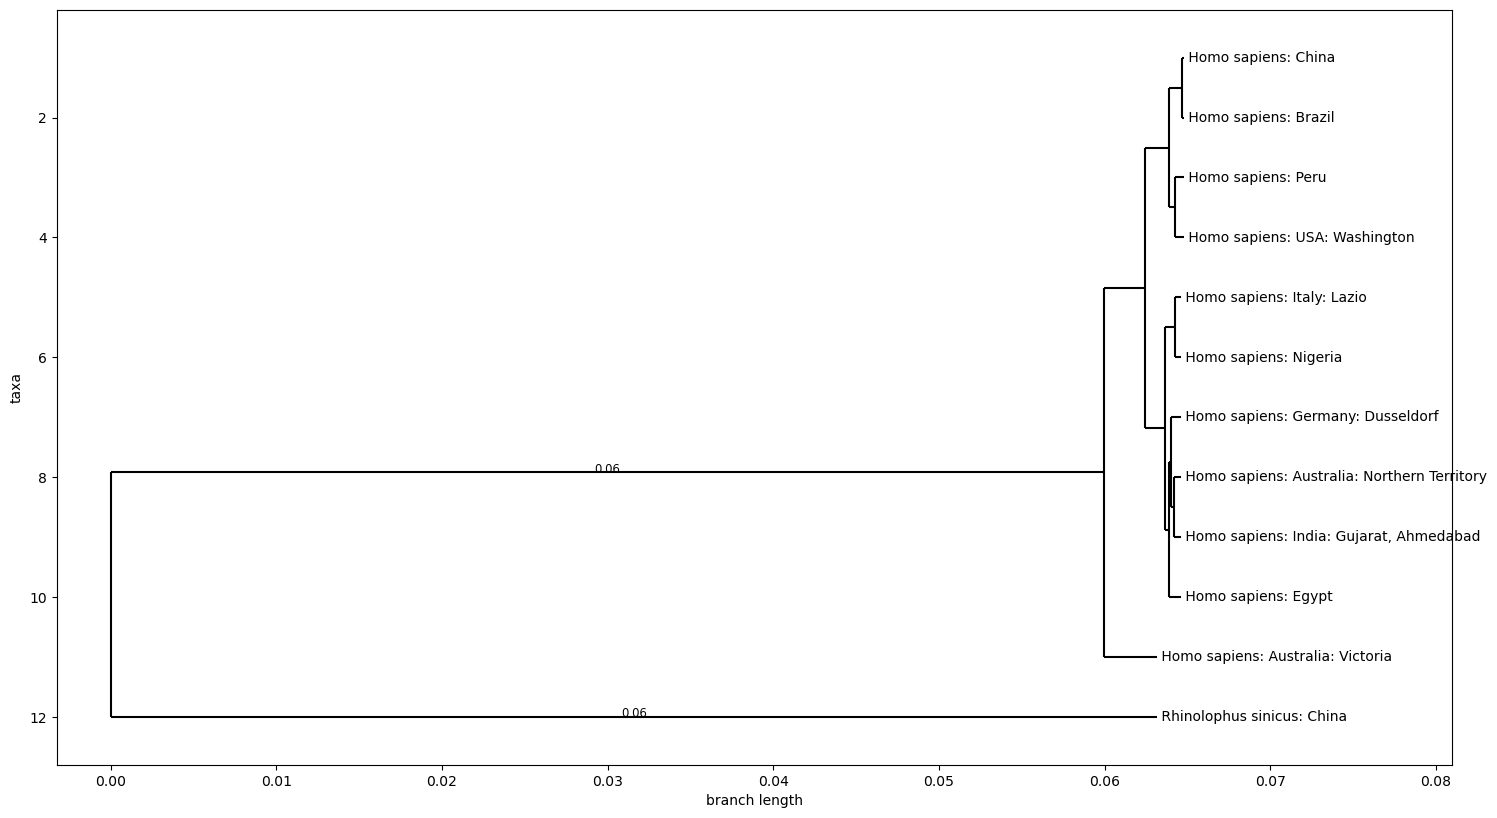

In [63]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('UPGMA_tree.png')


### Infer phyolgeny using the TreeTime algorithm
__1. TreeTime__ (Maximum Likelihood method):
- https://treetime.readthedocs.io/en/latest/tutorials.html
- temporally-resolved phylogeny
- considers the sequence alignments and is not solely based on sequential distance measures
- estimates the likelihood of a given tree topology to have produced the underlying data assuming a given model of evolution (relaxed-clock)
- evolutionary models provide time-dependent mutation probabilities
- reports topology with the highest likelihood (trees are scored)
- uses iqtree

installed with pip

command line program worked using collection date as date and accession id as name (accession ids in metadata and sequence names in alignment file need to match)

__Execution__:<br>
treetime --aln MSA.fasta --dates sequences_metadata.csv --date-column date --name-column Accession --outdir treetime_out


__2. Nextstrain:__
- https://nextstrain.org/docs/getting-started/introduction
- open-source tool for analysing and visualizing pathogen evolution and epidemiological spread
- for the purpose of scientific insights and improving outbreak respones in public health 
- Augur is the bioinformtaics toolkit of Nextstrain, Auspice is the visualization toolkit (https://docs.nextstrain.org/projects/augur/en/stable/usage/cli/refine.html)
- __Need to install nextstrain-augur and iqtree: !pip3 install nextstrain-augur, brew install brewsci/bio/iqtree__

uses iqtree for phylogeny inference and treetime algorithm for refinement

__Execution__:<br>
- infer tree from MSA: augur tree --alignment MSA.fasta --method iqtree --output augur_out/augur.out.nwk 

- get a time-resolved tree: augur refine --alignment MSA.fasta --tree augur_out/augur.out.nwk --metadata sequence_metadata.csv --output-tree augur_out/augur.out.refined.nwk --output-node-data augur_out/augur.refine.branches.json --timetree 

- annotate the tree with ancestral traits: augur traits --tree augur.out.refined.nwk --metadata ../sequence_metadata.csv --output traits.json --columns Geo_Location Host --confidence 
- infer ancestral sequence for each internal node (trace back mutations):  augur ancestral --tree augur.out.refined.nwk --alignment ../MSA.fasta --output-sequences nt_muts.json --inference joint
- export to auspice format: 
For sequence analysis and visualization follow the Zika tutorial: https://nextstrain.org/docs/tutorials/zika.

In [64]:
accession_metainfo

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus,country,region
0,MT658507.1,2020-06-23T00:00:00Z,Severe acute respiratory syndrome-related coro...,29799,Egypt,Homo sapiens,oronasopharynx,2020-06-02,MT658507.1,Severe acute respiratory syndrome-related coro...,Egypt,no_data
1,MT641501.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29868,USA: Washington,Homo sapiens,NaN,2020-04-11,MT641501.1,Severe acute respiratory syndrome-related coro...,USA,Washington
2,MT641645.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29813,Australia: Northern Territory,Homo sapiens,NaN,2020-02-21,MT641645.1,Severe acute respiratory syndrome-related coro...,Australia,Northern Territory
3,MT635269.1,2020-06-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,29800,"India: Gujarat, Ahmedabad",Homo sapiens,NaN,2020-06-03,MT635269.1,Severe acute respiratory syndrome-related coro...,India,"Gujarat, Ahmedabad"
4,MT582453.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582453.1,Severe acute respiratory syndrome-related coro...,Germany,Dusseldorf
5,MT576584.1,2020-06-08T00:00:00Z,Severe acute respiratory syndrome-related coro...,29760,Nigeria,Homo sapiens,NaN,2020-03-01,MT576584.1,Severe acute respiratory syndrome-related coro...,Nigeria,no_data
6,MT525950.1,2020-05-28T00:00:00Z,Severe acute respiratory syndrome-related coro...,29760,Italy: Lazio,Homo sapiens,oronasopharynx,2020-03-01,MT525950.1,Severe acute respiratory syndrome-related coro...,Italy,Lazio
7,MT451694.1,2020-05-11T00:00:00Z,Severe acute respiratory syndrome-related coro...,29812,Australia: Victoria,Homo sapiens,NaN,2020-04-01,MT451694.1,Severe acute respiratory syndrome-related coro...,Australia,Victoria
8,MT350282.1,2020-04-17T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,Brazil,Homo sapiens,NaN,2020-03-18,MT350282.1,Severe acute respiratory syndrome-related coro...,Brazil,no_data
9,MT263074.1,2020-03-31T00:00:00Z,Severe acute respiratory syndrome-related coro...,29856,Peru,Homo sapiens,NaN,2020-03-10,MT263074.1,Severe acute respiratory syndrome-related coro...,Peru,no_data


### Visualize phylogeny using Nextstrain auspice
Install: https://nextstrain.github.io/auspice/introduction/install

__Run in command line__

In [ ]:
augur = Phylo.read('augur_out/augur.out.refined.nwk', 'newick')

In [ ]:
print(augur)

In [ ]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(augur, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)


In [ ]:
treetime = Phylo.read('treetime_out/timetree.nexus', 'nexus')

In [ ]:
print(treetime)

In [ ]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(treetime, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)


# Cluster analysis in Germany

In [ ]:
#with open("clustering/MT582447.1") as f: 
#    data = f.readlines() 
#with open("clustering/MSA_Germany.fasta", "w") as f: 
#    for line in data: 
#        out = line.replace(">gb|", ">")
#        f.write(out) 

In [ ]:
align_germany = AlignIO.read("clustering/MSA_Germany.fasta", "fasta")
print(align_germany)

In [ ]:
#accession_metainfo = pd.read_csv("clustering/sequences.csv", index_col=0)
#
#accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
#accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')
#
## TreeTime and augur require the alignment file and metadata to have matching sequence names
#new_names = []
#for elem in accession_metainfo.index.values:
#    if elem.startswith('MN'):
#        new_names.append(elem+'.3')
#    else:
#        new_names.append(elem+'.1')
#accession_metainfo.index = new_names
#
## Nextstrain augur requires the metadata columns strain, virus and date
#accession_metainfo['strain'] = accession_metainfo.index
#accession_metainfo['virus'] = accession_metainfo.Species
#
#accession_metainfo.to_csv("clustering/sequence_metadata_germany.csv")

In [ ]:
accession_metainfo_germany = pd.read_csv("clustering/sequence_metadata_germany.csv", index_col=0)
accession_metainfo_germany.head()

In [ ]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm_germany = calculator.get_distance(align_germany)

In [ ]:
import seaborn as sns; sns.set(color_codes=True)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [ ]:
# transform the diagonal matrix into a full rank matrix
cols = [accession_metainfo_germany["Geo_Location"][x] for x in dm_germany.names]
df_germany = pd.DataFrame(dm_germany.matrix, columns=cols, index=cols)
maxi = df_germany.shape[0]
for i in range(0,maxi):
    for j in range(i+1,maxi):
        df_germany.iloc[i,j] = df_germany.iloc[j,i]
df_germany.head()

In [ ]:
#use the UPGMA scoring for clustering
#linkage = hc.linkage(sp.distance.squareform(df_germany), method="average")
g = sns.clustermap(df_germany, cmap="Blues", method="average")#, row_linkage=linkage, col_linkage=linkage)

In [ ]:
print("Mean Identity Distance in Germany:")
print(df_germany.mean().mean())

# Cluster analysis between Europe and Asia

In [ ]:
#with open("clustering/MT256917.1") as f: 
#    data = f.readlines() 
#with open("clustering/MSA_EU_vs_Asia.fasta", "w") as f: 
#    for line in data: 
#        out = line.replace(">gb|", ">")
#        out = out.replace(">dbj|", ">")
#        f.write(out) 

In [ ]:
align_eu_vs_asia = AlignIO.read("clustering/MSA_EU_vs_Asia.fasta", "fasta")
print(align_eu_vs_asia)

In [ ]:
#accession_metainfo = pd.read_csv("clustering/sequences2.csv", index_col=0)
#
#accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
#accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')
#
## TreeTime and augur require the alignment file and metadata to have matching sequence names
#new_names = []
#for elem in accession_metainfo.index.values:
#    new_names.append(elem+'.1')
#accession_metainfo.index = new_names
#
## Nextstrain augur requires the metadata columns strain, virus and date
#accession_metainfo['strain'] = accession_metainfo.index
#accession_metainfo['virus'] = accession_metainfo.Species
#
#accession_metainfo.to_csv("clustering/sequence_metadata_eu_vs_asia.csv")

In [ ]:
accession_metainfo_eu_vs_asia = pd.read_csv("clustering/sequence_metadata_eu_vs_asia.csv", index_col=0)
accession_metainfo_eu_vs_asia.head()

In [ ]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm_eu_vs_asia = calculator.get_distance(align_eu_vs_asia)

In [ ]:
#import seaborn as sns; sns.set(color_codes=True)
#import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [ ]:
# transform the diagonal matrix into a full rank matrix
cols = [accession_metainfo_eu_vs_asia["Geo_Location"][x] for x in dm_eu_vs_asia.names]
df_eu_vs_asia = pd.DataFrame(dm_eu_vs_asia.matrix, columns=cols, index=cols)
maxi = df_eu_vs_asia.shape[0]
for i in range(0,maxi):
    for j in range(i+1,maxi):
        df_eu_vs_asia.iloc[i,j] = df_eu_vs_asia.iloc[j,i]
df_eu_vs_asia.head()

In [ ]:
# manual assignment for grouping the samples by continent
accession_metainfo_eu_vs_asia["Continent"] = ["Asia", "Europe", "Asia", "Asia", "Europe", "Europe", "Europe", "Europe", "Asia", "Asia", "Asia", "Asia", "Europe", "Europe", "Asia", "Europe", "Europe", "Europe", "Asia", "Asia"]
accession_metainfo_eu_vs_asia["Continent"].value_counts()

In [ ]:
accession_metainfo_eu_vs_asia[["Geo_Location","Continent"]]

In [ ]:
lut = dict(zip(accession_metainfo_eu_vs_asia["Continent"].unique(), "rg"))
lut2 = accession_metainfo_eu_vs_asia["Continent"].map(lut)
row_colors = [lut2[x] for x in dm_eu_vs_asia.names]

In [ ]:
#use the UPGMA scoring for clustering
#linkage2 = hc.linkage(sp.distance.squareform(df_eu_vs_asia), method="average")
print("Colours: ", lut)
g = sns.clustermap(df_eu_vs_asia, cmap="Blues", row_colors=row_colors, method="average")#, row_linkage=linkage2, col_linkage=linkage2)

In [ ]:
asia_list = accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia["Continent"]=="Asia"]["Geo_Location"].values
europe_list = accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia["Continent"]=="Europe"]["Geo_Location"].values

In [ ]:
print("Mean Identity Distance between Europe and Asia:")
print((df_eu_vs_asia.filter(items=europe_list, axis=1).filter(items=asia_list, axis=0).mean().mean() + 
     df_eu_vs_asia.filter(items=asia_list, axis=1).filter(items=europe_list, axis=0).mean().mean()) / 2)
print("Mean Identity Distance in Europe:")
print(df_eu_vs_asia.filter(items=europe_list, axis=1).filter(items=europe_list, axis=0).mean().mean())
print("Mean Identity Distance in Asia:")
print(df_eu_vs_asia.filter(items=asia_list, axis=1).filter(items=asia_list, axis=0).mean().mean())
print("Mean Identity Distance total:")
print(df_eu_vs_asia.mean().mean())